In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import nbformat as nbf

In [4]:
# -----------------------------
# 1) Create synthetic time series
# -----------------------------
rng = pd.date_range("2024-01-01", "2025-06-30", freq="D")
n = len(rng)
np.random.seed(7)

In [5]:
# Base components
trend = np.linspace(100, 200, n)                          # upward trend
weekly = 10 * np.sin(2 * np.pi * np.arange(n) / 7)        # weekly seasonality
noise = np.random.normal(0, 8, n)                         # random noise

sales = trend + weekly + noise
traffic = 1500 + 120 * np.sin(2 * np.pi * np.arange(n) / 7 + 1.2) + np.random.normal(0, 50, n)
conv_rate = 0.025 + 0.005 * np.sin(2 * np.pi * np.arange(n) / 30) + np.random.normal(0, 0.002, n)
conv_rate = np.clip(conv_rate, 0.01, 0.05)
conversions = np.maximum(0, (traffic * conv_rate).astype(int))

In [6]:
# Introduce some missingness in traffic to show gaps
traffic_missing = traffic.copy()
missing_idx = np.random.choice(np.arange(n), size=int(0.03*n), replace=False)
traffic_missing[missing_idx] = np.nan

# Simple campaign windows to highlight later
campaigns = [
    ("2024-03-10", "2024-03-20"),
    ("2024-11-25", "2024-12-05"),
    ("2025-05-01", "2025-05-10"),
]

df = pd.DataFrame({
    "date": rng,
    "sales": sales,
    "traffic": traffic,
    "traffic_with_gaps": traffic_missing,
    "conversion_rate": conv_rate,
    "conversions": conversions,
})
df["month"] = df["date"].dt.to_period("M").astype(str)


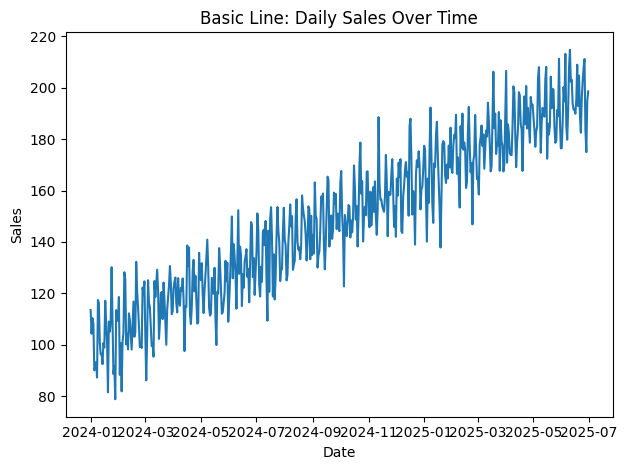

In [7]:
# -----------------------------
# 2) Common line charts (each in its own figure)
# -----------------------------

# 2.1 Basic line: sales over time
plt.figure()
plt.plot(df["date"], df["sales"])
plt.title("Basic Line: Daily Sales Over Time")
plt.xlabel("Date"); plt.ylabel("Sales")
plt.tight_layout(); plt.show()

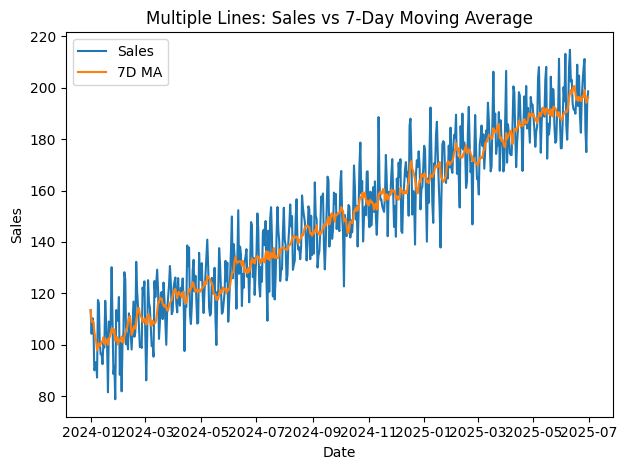

In [8]:
# 2.2 Multiple lines on same axes: sales and 7D moving average
df["sales_ma7"] = df["sales"].rolling(7, min_periods=1).mean()
plt.figure()
plt.plot(df["date"], df["sales"], label="Sales")
plt.plot(df["date"], df["sales_ma7"], label="7D MA")
plt.title("Multiple Lines: Sales vs 7-Day Moving Average")
plt.xlabel("Date"); plt.ylabel("Sales"); plt.legend()
plt.tight_layout(); plt.show()


/tmp/ipython-input-1243497960.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.set_index("date")["sales"].resample("M").sum()


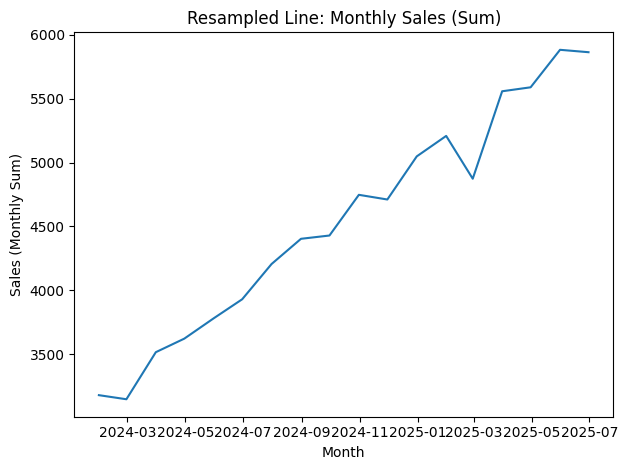

In [9]:
# 2.3 Resampled monthly totals: monthly sales line
monthly_sales = df.set_index("date")["sales"].resample("M").sum()
plt.figure()
plt.plot(monthly_sales.index, monthly_sales.values)
plt.title("Resampled Line: Monthly Sales (Sum)")
plt.xlabel("Month"); plt.ylabel("Sales (Monthly Sum)")
plt.tight_layout(); plt.show()


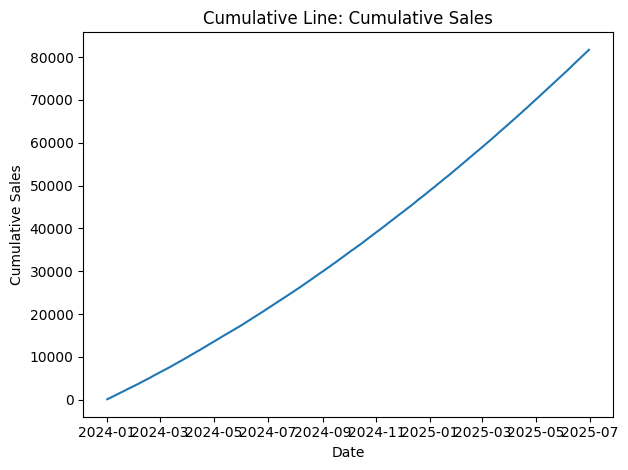

In [10]:
# 2.4 Cumulative line: cumulative sales
cumulative_sales = df["sales"].cumsum()
plt.figure()
plt.plot(df["date"], cumulative_sales)
plt.title("Cumulative Line: Cumulative Sales")
plt.xlabel("Date"); plt.ylabel("Cumulative Sales")
plt.tight_layout(); plt.show()

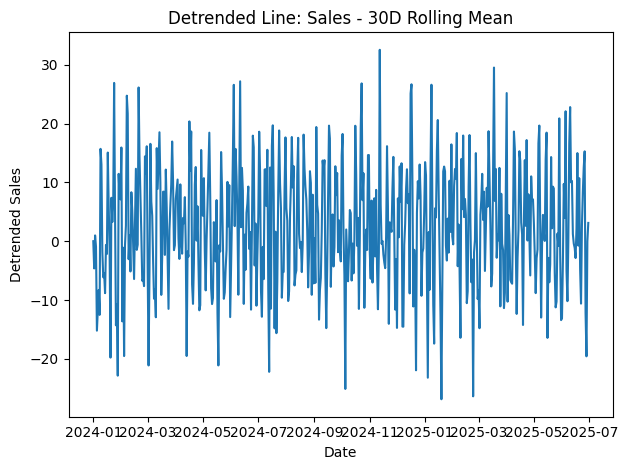

In [11]:
# 2.5 Detrended line: sales minus 30D rolling mean
df["sales_ma30"] = df["sales"].rolling(30, min_periods=1).mean()
detrended = df["sales"] - df["sales_ma30"]
plt.figure()
plt.plot(df["date"], detrended)
plt.title("Detrended Line: Sales - 30D Rolling Mean")
plt.xlabel("Date"); plt.ylabel("Detrended Sales")
plt.tight_layout(); plt.show()

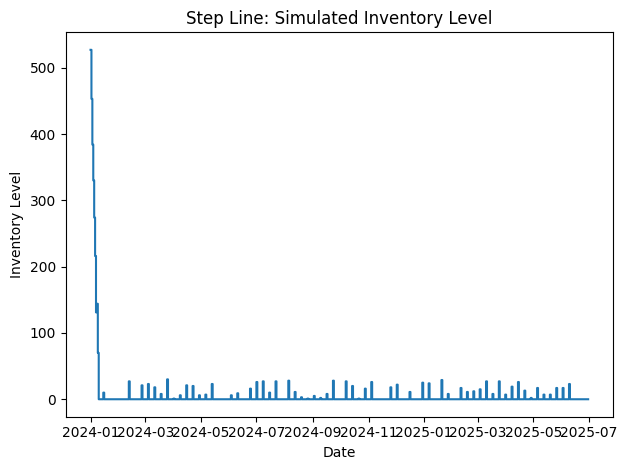

In [12]:
# 2.6 Step line: inventory level (simulated weekly restock pattern)
#    Build a simple step-like series
inventory = []
level = 500
for i in range(n):
    if i % 7 == 0:  # weekly restock
        level += 80
    level -= np.random.randint(50, 90)  # daily depletion
    level = max(level, 0)
    inventory.append(level)
plt.figure()
plt.step(df["date"], inventory, where="post")
plt.title("Step Line: Simulated Inventory Level")
plt.xlabel("Date"); plt.ylabel("Inventory Level")
plt.tight_layout(); plt.show()

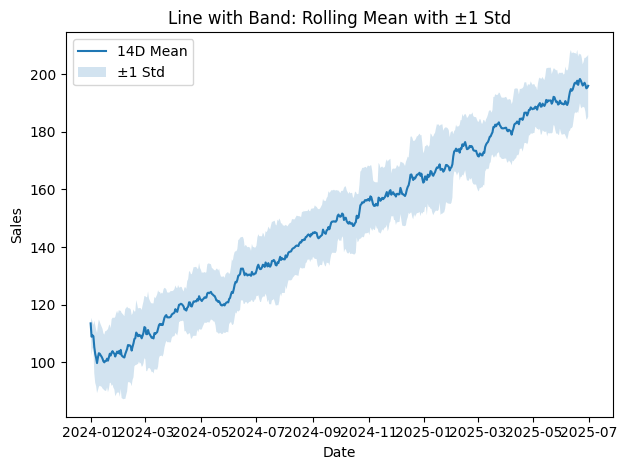

In [13]:
# 2.7 Line with confidence band: rolling mean ± 1 std
roll_mean = df["sales"].rolling(14, min_periods=1).mean()
roll_std = df["sales"].rolling(14, min_periods=1).std().fillna(0)
upper = roll_mean + roll_std
lower = roll_mean - roll_std
plt.figure()
plt.plot(df["date"], roll_mean, label="14D Mean")
plt.fill_between(df["date"], lower, upper, alpha=0.2, label="±1 Std")
plt.title("Line with Band: Rolling Mean with ±1 Std")
plt.xlabel("Date"); plt.ylabel("Sales"); plt.legend()
plt.tight_layout(); plt.show()


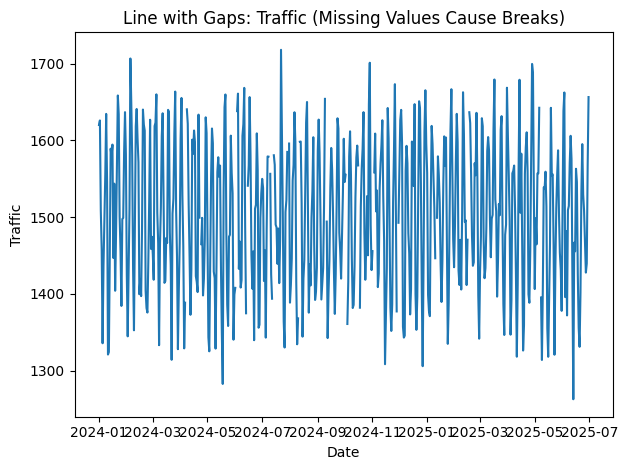

In [14]:
# 2.8 Line with missing data (gaps visible)
plt.figure()
plt.plot(df["date"], df["traffic_with_gaps"])
plt.title("Line with Gaps: Traffic (Missing Values Cause Breaks)")
plt.xlabel("Date"); plt.ylabel("Traffic")
plt.tight_layout(); plt.show()


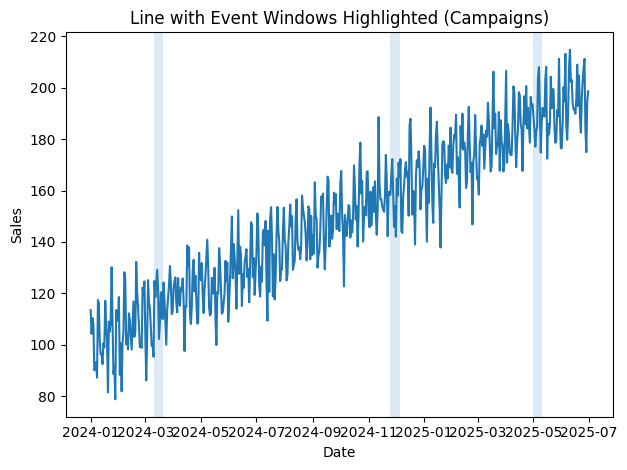

In [15]:
# 2.9 Line with event highlights (campaign windows)
plt.figure()
plt.plot(df["date"], df["sales"])
for start, end in campaigns:
    start_dt = pd.to_datetime(start); end_dt = pd.to_datetime(end)
    plt.axvspan(start_dt, end_dt, alpha=0.15)
plt.title("Line with Event Windows Highlighted (Campaigns)")
plt.xlabel("Date"); plt.ylabel("Sales")
plt.tight_layout(); plt.show()


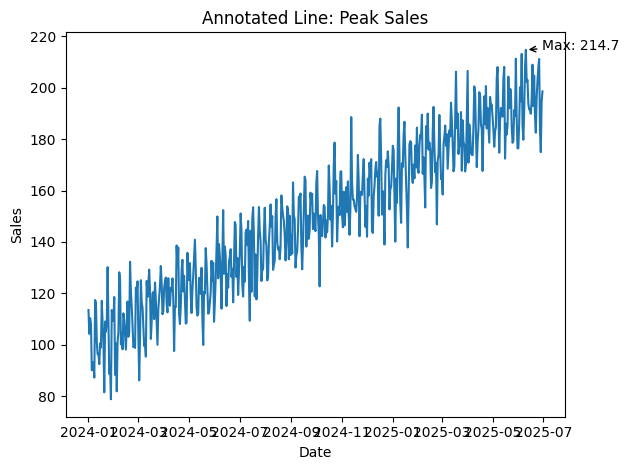

In [16]:
# 2.10 Annotated line: mark the max sales point
max_idx = df["sales"].idxmax()
max_date = df.loc[max_idx, "date"]
max_val = df.loc[max_idx, "sales"]
plt.figure()
plt.plot(df["date"], df["sales"])
plt.annotate(f"Max: {max_val:.1f}", xy=(max_date, max_val), xytext=(max_date + pd.Timedelta(days=20), max_val),
             arrowprops=dict(arrowstyle="->"))
plt.title("Annotated Line: Peak Sales")
plt.xlabel("Date"); plt.ylabel("Sales")
plt.tight_layout(); plt.show()


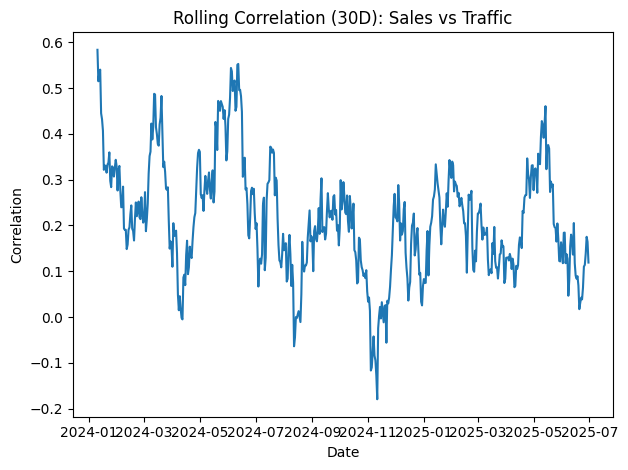

In [17]:
# 2.11 Rolling correlation line: sales vs traffic (30D window)
roll_corr = df[["sales","traffic"]].rolling(30, min_periods=10).corr().reset_index()
# Extract correlation series between 'sales' and 'traffic'
roll_corr_series = roll_corr[(roll_corr["level_1"]=="traffic") & (roll_corr["level_0"]!="")].copy()
roll_corr_series = roll_corr_series.set_index("level_0").sort_index()
# Because of the way rolling corr expands, align back to dates:
aligned_dates = df["date"].iloc[-len(roll_corr_series):]
plt.figure()
plt.plot(aligned_dates, roll_corr_series["sales"].values)
plt.title("Rolling Correlation (30D): Sales vs Traffic")
plt.xlabel("Date"); plt.ylabel("Correlation")
plt.tight_layout(); plt.show()


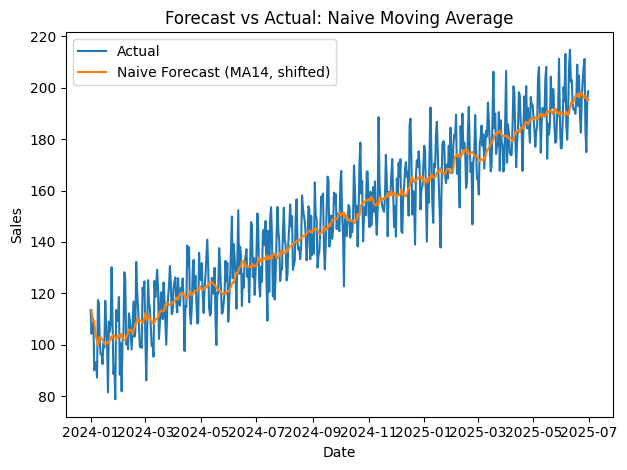

In [19]:
# 2.12 Forecast vs actual (very simple): 14D moving average as naive forecast
forecast = df["sales_ma14"] = df["sales"].rolling(14, min_periods=1).mean().shift(1)
plt.figure()
plt.plot(df["date"], df["sales"], label="Actual")
plt.plot(df["date"], forecast, label="Naive Forecast (MA14, shifted)")
plt.title("Forecast vs Actual: Naive Moving Average")
plt.xlabel("Date"); plt.ylabel("Sales"); plt.legend()
plt.tight_layout(); plt.show()